# Наивный Байес и спам
__Суммарное количество баллов: 10__


In [88]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import spacy
from nltk.stem.snowball import SnowballStemmer
import math
import re

In [89]:
import re
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x = []
    y = []
    for line in file:
        cl, sms = re.split("^(ham|spam)[\t\s]+(.*)$", line)[1:3]
        x.append(sms)
        y.append(cl)
    return np.array(x, dtype=np.str), np.array(y, dtype=np.str)

In [90]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1
    precision = dict((c, true_positive[c] / (true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, true_positive[c] / (true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, X_test, y_test, bow_method, voc_sizes=range(4, 200, 5)):
    classes = np.unique(list(y_train) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_limit=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

In [91]:
X, y = read_dataset("spam")

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

### Задание 1 (3 балла)
Реализуйте классификацию методом Байеса в предположении независимости компонент `x`. При реализации следует считать, что значения каждой компоненты дискретны, а `p(x|y)` имеет мультиномиальное распределение.

#### Методы
`fit(X, y)` - оценивает параметры распределения `p(x|y)` для каждого `y`. 

`log_proba(X)` - для каждого элемента набора `X` считает логарифм вероятности отнести его к каждому классу. По теореме Байеса: `p(y|x) = p(y)p(x|y)/p(x)`. Соответственно, после логарифмирования: `log p(y|x) = log p(y) + log p(x|y) - log p(x)`. Поскольку `log p(x)` является независящей от класса `y` константой, это слагаемое никак не влияет на решение задачи максимизации. Поэтому его можно просто убрать для простоты.

In [124]:
class NaiveBayes:
    def __init__(self, alpha):
        self.alpha = alpha # Параметр аддитивной регуляризации
        self.count_y = [0]*2
        self.classes = [0, 1]
        self.p_X = []
    
    def fit(self, X, y):
        all_el = [0]*2
        self.p_X = [0]*2
        self.p_X[0] = [0]*len(X[0])
        self.p_X[1] = [0]*len(X[0])
        for i in range(len(y)):
            self.count_y[y[i]] += 1
            for j in range(len(X[0])):
                self.p_X[y[i]][j] += X[i][j]
                all_el[y[i]] += X[i][j]
                
        for j in range(len(X[0])):
            self.p_X[0][j] += self.alpha
            self.p_X[1][j] += self.alpha
            self.p_X[0][j] /= (all_el[0] + len(X[0]) * self.alpha)
            self.p_X[1][j] /= (all_el[1] + len(X[0]) * self.alpha)
            
        
    def predict(self, X):
        return [self.classes[i] for i in np.argmax(self.log_proba(X), axis=0)]
    
    def log_proba(self, X):
        prob = [0]*2
        prob[0] = [0]*len(X)
        prob[1] = [0]*len(X)
        p_y = [0]*2
        p_y[0] = self.count_y[0]/(self.count_y[0] + self.count_y[1])
        p_y[1] = self.count_y[1]/(self.count_y[0] + self.count_y[1])
        
        for i in range(2):
            for j in range(len(X)):
                prob[i][j] = math.log(p_y[i])
                for feature in range(len(X[0])):
                    for count in range(X[j][feature]):
                        prob[i][j] += math.log(self.p_X[i][feature])

    
        return prob

### Задание 2 (3 балла)
Теперь реализуем метод bag of words. Задача состоит в том, чтобы посчитать количество вхождений каждого слова в предложение.

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [118]:
class BoW:
    def __init__(self, X, voc_limit=1000):
        self.bow = {}
        self.voc_limit = voc_limit
        self.create_dict(X)

                    
    def create_dict(self, X):
        for line in X:
            line = line.lower()
            line = re.split("[\s.!?,\"-)(\+:]", line)
            for el in line:
                if el != '':
                    if re.fullmatch("\d+", el):
                        self.bow['num'] = self.bow.setdefault('num', 0) + 1
                    if re.fullmatch("[a-z]+", el):
                        self.bow[el] = self.bow.setdefault(el, 0) + 1
                    if re.fullmatch("£\d+", el):
                        self.bow['money'] = self.bow.setdefault('money', 0) + 1    
        
        count = 1
        while len(self.bow) > self.voc_limit:
            count += 1
            copy = self.bow.copy()
            for el in copy.keys():
                if self.bow[el] < count:
                    v = self.bow.pop(el)
        
    def transform(self, X):
        dict_number = {}
        table = [[0] * len(self.bow) for i in range(len(X))]
        
        i = 0
        for el in self.bow.keys():
            dict_number[el] = i
            i += 1
        
        for i in range(len(X)):
            line = X[i]
            line = line.lower()
            line = re.split("[\s.!?,\"-)(\+:]", line)
            for el in line:
                if el != '':
                    if re.fullmatch("\d+", el) and 'num' in dict_number:
                        table[i][dict_number['num']] += 1
                    if re.fullmatch("[a-z]+", el) and el in dict_number:
                        table[i][dict_number[el]] += 1
                    if re.fullmatch("£[a-z]+", el) and 'money' in dict_number:
                        table[i][dict_number['money']] += 1 
        return table
                

In [119]:
bow = BoW(X_train, voc_limit=500)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)

In [125]:
predictor = NaiveBayes(0.001)
new_y_train = [0]*len(y_train)
new_y_test = [0]*len(y_test)
for i in range(len(y_train)):
    if y_train[i] == 'spam':
        new_y_train[i] = 1
for i in range(len(y_test)):
    if y_test[i] == 'spam':
        new_y_test[i] = 1
predictor.fit(X_train_bow, new_y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bow), new_y_test)


({0: 0.9853862212943633, 1: 0.9620253164556962},
 {0: 0.9936842105263158, 1: 0.9156626506024096},
 0.982078853046595)

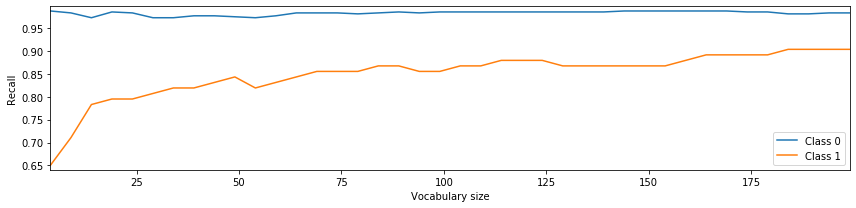

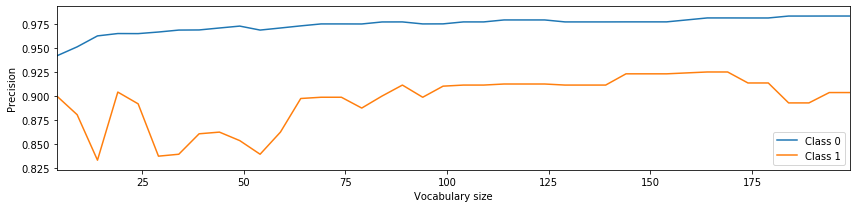

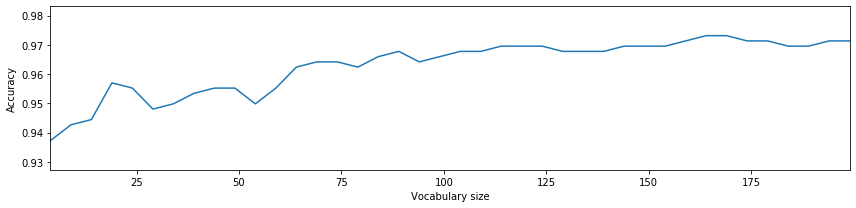

In [126]:
plot_precision_recall(X_train, new_y_train, X_test, new_y_test, BoW)

### Задание 3 (2 балла)
Теперь добавим в BoW стемминг. Для этого нам понадобится класс SnowballStemmer из пакета `nltk`

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [134]:
class BowStem:
    def __init__(self, X, voc_limit=1000):
        self.bow = {}
        self.voc_limit = voc_limit
        self.create_dict(X)

                    
    def create_dict(self, X):
        stemmer = SnowballStemmer("english")
        for line in X:
            line = line.lower()
            line = re.split("[\s.!?,\"-)(\+:]", line)
            for el in line:
                if el != '':
                    if re.fullmatch("\d+", el):
                        self.bow['num'] = self.bow.setdefault('num', 0) + 1
                    if re.fullmatch("[a-z]+", el):
                        el = stemmer.stem(el)
                        self.bow[el] = self.bow.setdefault(el, 0) + 1
                    if re.fullmatch("£\d+", el):
                        self.bow['money'] = self.bow.setdefault('money', 0) + 1    
        
        count = 1
        while len(self.bow) > self.voc_limit:
            count += 1
            copy = self.bow.copy()
            for el in copy.keys():
                if self.bow[el] < count:
                    v = self.bow.pop(el)
    
    
        
    def transform(self, X):
        stemmer = SnowballStemmer("english")
        dict_number = {}
        table = [[0] * len(self.bow) for i in range(len(X))]
        
        i = 0
        for el in self.bow.keys():
            dict_number[el] = i
            i += 1
        
        for i in range(len(X)):
            line = X[i]
            line = line.lower()
            line = re.split("[\s.!?,\"-)(\+:]", line)
            for el in line:
                if el != '':
                    if re.fullmatch("\d+", el) and 'num' in dict_number:
                        table[i][dict_number['num']] += 1
                    if re.fullmatch("[a-z]+", el) and el in dict_number:
                        el = stemmer.stem(el)
                        table[i][dict_number[el]] += 1
                    if re.fullmatch("£[a-z]+", el) and 'money' in dict_number:
                        table[i][dict_number['money']] += 1 
        return table

In [135]:
bows = BowStem(X_train, voc_limit=500)
X_train_bows = bows.transform(X_train)
X_test_bows = bows.transform(X_test)

In [136]:
predictor = NaiveBayes(0.001)
new_y_train = [0]*len(y_train)
new_y_test = [0]*len(y_test)
for i in range(len(y_train)):
    if y_train[i] == 'spam':
        new_y_train[i] = 1
for i in range(len(y_test)):
    if y_test[i] == 'spam':
        new_y_test[i] = 1
predictor.fit(X_train_bow, new_y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bow), new_y_test)

({0: 0.9853862212943633, 1: 0.9620253164556962},
 {0: 0.9936842105263158, 1: 0.9156626506024096},
 0.982078853046595)

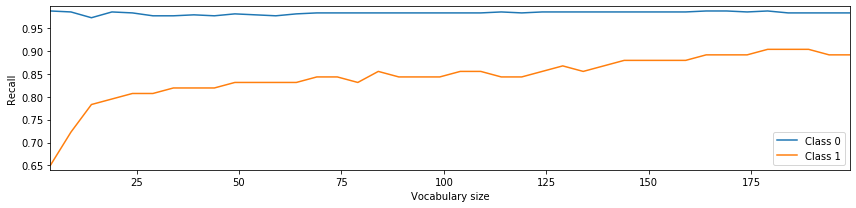

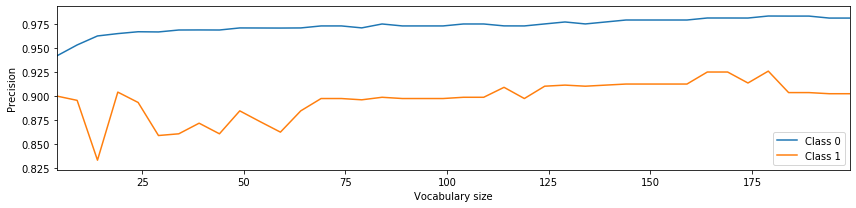

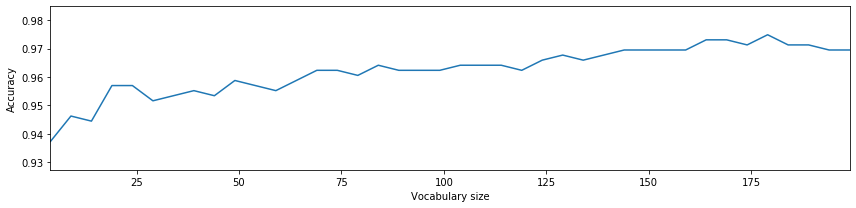

In [137]:
plot_precision_recall(X_train, new_y_train, X_test, new_y_test, BowStem)